# Step 1: Preprocessing with Feature Mapping (using ResNet18)


In [1]:
import os
import pennylane as qml
from pennylane import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torchvision.transforms as transforms
from torchvision import models

# Constants
SOI_PATH = '/home/HardDisk/yared/spectrogram-dataset/soi'
CWI_PATH = '/home/HardDisk/yared/spectrogram-dataset/cwi'
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32

# Preprocessing and ResNet feature extractor
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove last layer
resnet = resnet.to(device)

# Updated transformation pipeline
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels (RGB)
    transforms.ToTensor()
])

def load_images(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)
            img_tensor = transform(img).unsqueeze(0).to(device)
            features = resnet(img_tensor).cpu().detach().numpy().flatten()
            images.append(features)
            labels.append(label)
    return images, labels

# Load images and labels
soi_images, soi_labels = load_images(SOI_PATH, 0)
cwi_images, cwi_labels = load_images(CWI_PATH, 1)

# Combine and normalize features
X = np.array(soi_images + cwi_images)
X = (X - X.min()) / (X.max() - X.min())  # Normalize to [0, 1]

# Apply PCA for dimensionality reduction
pca = PCA(n_components=10)  # I can further adjust the number of components; maybe later
X_reduced = pca.fit_transform(X)

# Combine labels
y = np.array(soi_labels + cwi_labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42, stratify=y)

# Example output shapes
print(f'Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}')
print(f'Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}')


/home/ea301b/anaconda3/envs/Pennylane/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ea301b/anaconda3/envs/Pennylane/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training data shape: (6532, 10), Training labels shape: (6532,)
Testing data shape: (1634, 10), Testing labels shape: (1634,)


In [2]:
# Check the number of samples in each label for training and testing sets
train_labels, train_counts = np.unique(y_train, return_counts=True)
test_labels, test_counts = np.unique(y_test, return_counts=True)

# Print the number of samples for each label in the training set
print("Training set label distribution:")
for label, count in zip(train_labels, train_counts):
    print(f'Label {label}: {count} samples')

# Print the number of samples for each label in the testing set
print("Testing set label distribution:")
for label, count in zip(test_labels, test_counts):
    print(f'Label {label}: {count} samples')

Training set label distribution:
Label 0: 4767 samples
Label 1: 1765 samples
Testing set label distribution:
Label 0: 1193 samples
Label 1: 441 samples


# Step 2: Define the Quantum Circuit and QNN

In [3]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import torch

# Quantum device setup
n_qubits = 6  # Adjust based on the number of qubits needed
dev = qml.device("default.qubit", wires=n_qubits)

# Define the quantum circuit
@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    """Define a variational quantum circuit that matches the specified LaTeX structure."""

    # Step 1: Apply Hadamard gates to each qubit as per the initial superposition setup
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Step 2: Apply specific rotation gates on specified qubits
    qml.RX(inputs[0], wires=0)  # Rx on qubit 1
    qml.RY(inputs[1], wires=0)  # Ry on qubit 1
    qml.RZ(inputs[2], wires=1)  # Rz on qubit 2
    qml.RY(inputs[3], wires=2)  # Ry on qubit 3
    qml.RZ(inputs[4], wires=2)  # Rz on qubit 3
    qml.RX(inputs[5], wires=3)  # Rx on qubit 4

    # Step 3: Apply unitary gates (U(alpha), U(beta), ...) as U3 gates
    qml.U3(weights[0, 0, 0], weights[0, 0, 1], weights[0, 0, 2], wires=0)  # U(alpha) on qubit 1
    qml.U3(weights[0, 1, 0], weights[0, 1, 1], weights[0, 1, 2], wires=1)  # U(beta) on qubit 2
    qml.U3(weights[0, 2, 0], weights[0, 2, 1], weights[0, 2, 2], wires=2)  # U(delta) on qubit 3
    qml.U3(weights[0, 3, 0], weights[0, 3, 1], weights[0, 3, 2], wires=3)  # U(epsilon) on qubit 4
    qml.U3(weights[0, 4, 0], weights[0, 4, 1], weights[0, 4, 2], wires=4)  # U(zeta) on qubit 5
    qml.U3(weights[0, 5, 0], weights[0, 5, 1], weights[0, 5, 2], wires=5)  # U(eta) on qubit 6

    # Step 4: Apply entangling CNOT gates to match specified connections
    qml.CNOT(wires=[0, 1])  # Control qubit 1 to target qubit 2
    qml.CNOT(wires=[0, 2])  # Control qubit 1 to target qubit 3
    qml.CNOT(wires=[4, 3])  # Control qubit 4 to target qubit 5
    qml.CNOT(wires=[3, 2])  # Control qubit 4 to target qubit 3
    qml.CNOT(wires=[4, 5])  # Control qubit 4 to target qubit 3

    # Step 5: Measurements on all qubits
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define the weight shape dictionary for TorchLayer
weights_shape = {"weights": (1, n_qubits, 3)}

# QNN model that uses the defined quantum circuit
qnn = qml.qnn.TorchLayer(quantum_circuit, weights_shape)

# Visualize the circuit
inputs = np.random.rand(n_qubits)  # Random input values for the gates
weights = np.random.rand(1, n_qubits, 3)  # Random weights for the U3 unitaries
# fig, ax = qml.draw_mpl(quantum_circuit)(inputs, weights)
# plt.show()


# Step 3: Combine ResNet-18 and QNN for Classification

In [4]:
import torch.nn as nn

class HybridModel(nn.Module):
    def __init__(self, input_size):
        super(HybridModel, self).__init__()
        self.fc = nn.Linear(input_size, n_qubits)  # ResNet18 output to qubit input size
        self.qnn = qnn
        self.output = nn.Linear(n_qubits, 1)  # Binary classification
    
    def forward(self, x):
        x = self.fc(x)
        x = self.qnn(x)
        x = torch.sigmoid(self.output(x))
        return x

# Step 4: Train and Evaluate the Model

In [5]:
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch

# Assuming `X_train`, `y_train`, `X_test`, `y_test`, `BATCH_SIZE`, and `HybridModel` from above

input_size = X_reduced.shape[1]  # Number of features after PCA
model = HybridModel(input_size=input_size).cuda()

# Prepare data loaders
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Initialize lists to store loss and accuracy values
loss_values = []
accuracy_values = []
val_losses = []
val_accuracy_values = []

# # Ensure y_train is converted to a NumPy array to calculate class counts
# y_train_np = y_train.numpy() if isinstance(y_train, torch.Tensor) else np.array(y_train)

# Calculate class counts with return_counts=True
class_labels, class_counts = np.unique(y_train, return_counts=True)
total_samples = len(y_train)

# Calculate class weights for balanced weighting
class_weights = [total_samples / (2 * count) for count in class_counts]

# Convert class weights to a tensor
weights_tensor = torch.tensor(class_weights, dtype=torch.float32).cuda()


# Adjusted training function with class weights
def train_model(epochs):
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        total_loss = 0
        correct = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            optimizer.zero_grad()
            
            output = model(X_batch).squeeze(1)  # Squeeze to match shape
            # Apply class weights based on the labels
            weights = weights_tensor[y_batch.long()]  # Select weights for current batch
            
            loss = F.binary_cross_entropy(output, y_batch, weight=weights)  # Weighted loss
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            correct += ((output > 0.5) == y_batch).float().sum().item()  # Calculate correct predictions

        # Calculate average loss and accuracy for the epoch
        avg_loss = total_loss / len(train_loader)
        accuracy = correct / len(train_loader.dataset)
        
        loss_values.append(avg_loss)
        accuracy_values.append(accuracy)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        val_correct = 0
        with torch.no_grad():  # Disable gradient calculation for validation
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
                output = model(X_batch).squeeze(1)
                loss = F.binary_cross_entropy(output, y_batch)
                val_loss += loss.item()
                val_correct += ((output > 0.5) == y_batch).float().sum().item()

        avg_val_loss = val_loss / len(test_loader)
        val_accuracy = val_correct / len(test_loader.dataset)
        
        val_losses.append(avg_val_loss)
        val_accuracy_values.append(val_accuracy)

        print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Train the model with class weights applied
train_model(epochs=25)


Epoch 1, Loss: 0.6916, Accuracy: 0.7038, Val Loss: 0.6846, Val Accuracy: 0.7246
Epoch 2, Loss: 0.6817, Accuracy: 0.6744, Val Loss: 0.6810, Val Accuracy: 0.6395
Epoch 3, Loss: 0.6650, Accuracy: 0.6863, Val Loss: 0.6560, Val Accuracy: 0.6879
Epoch 4, Loss: 0.6301, Accuracy: 0.7223, Val Loss: 0.5890, Val Accuracy: 0.7130
Epoch 5, Loss: 0.5542, Accuracy: 0.7261, Val Loss: 0.5376, Val Accuracy: 0.7062
Epoch 6, Loss: 0.5116, Accuracy: 0.7307, Val Loss: 0.5387, Val Accuracy: 0.7062
Epoch 7, Loss: 0.4975, Accuracy: 0.7371, Val Loss: 0.5323, Val Accuracy: 0.7142
Epoch 8, Loss: 0.4892, Accuracy: 0.7420, Val Loss: 0.5296, Val Accuracy: 0.7142
Epoch 9, Loss: 0.4789, Accuracy: 0.7422, Val Loss: 0.5093, Val Accuracy: 0.7228
Epoch 10, Loss: 0.4701, Accuracy: 0.7520, Val Loss: 0.5064, Val Accuracy: 0.7264
Epoch 11, Loss: 0.4634, Accuracy: 0.7622, Val Loss: 0.5056, Val Accuracy: 0.7326
Epoch 12, Loss: 0.4593, Accuracy: 0.7653, Val Loss: 0.5028, Val Accuracy: 0.7368
Epoch 13, Loss: 0.4567, Accuracy: 0.7

In [6]:
# Evaluation function
def evaluate():
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch).squeeze(1)  # Squeeze to match shape
            y_pred.extend((output > 0.5).cpu().numpy())  # Convert probabilities to binary predictions
            y_true.extend(y_batch.cpu().numpy())
    return y_true, y_pred

y_true, y_pred = evaluate()

# Combine the loss and accuracy values into one graph

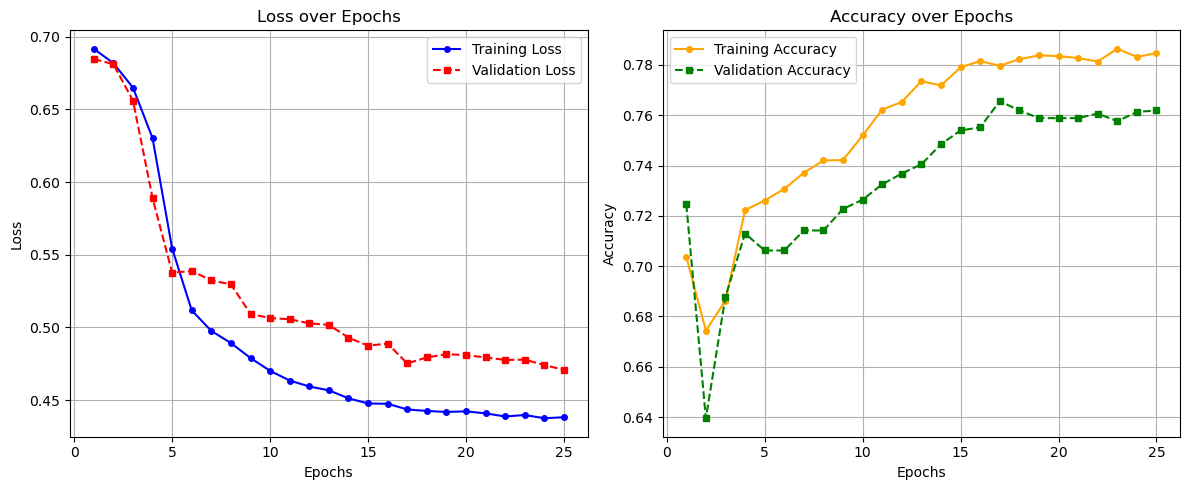

In [7]:
import matplotlib.pyplot as plt

# Function to plot loss and accuracy
def plot_loss_accuracy(loss_values, val_losses, accuracy_values, val_accuracy_values):
    epochs = range(1, len(loss_values) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss (Training and Validation)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_values, label='Training Loss', color='blue', marker='o', markersize=4, linestyle='-')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red', marker='s', markersize=4, linestyle='--')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    # Plot Accuracy (Training and Validation)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy_values, label='Training Accuracy', color='orange', marker='o', markersize=4, linestyle='-')
    plt.plot(epochs, val_accuracy_values, label='Validation Accuracy', color='green', marker='s', markersize=4, linestyle='--')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function after training
plot_loss_accuracy(loss_values, val_losses, accuracy_values, val_accuracy_values)


# Step 5: Visualize Results

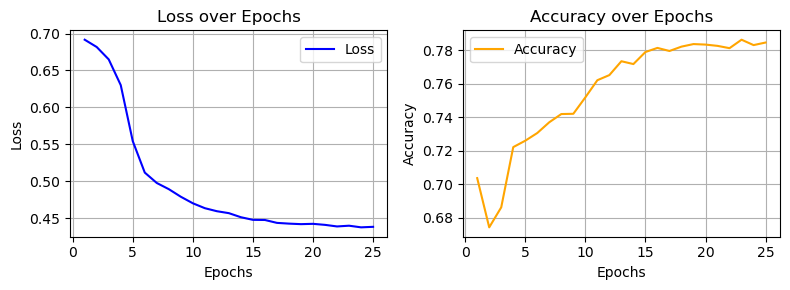

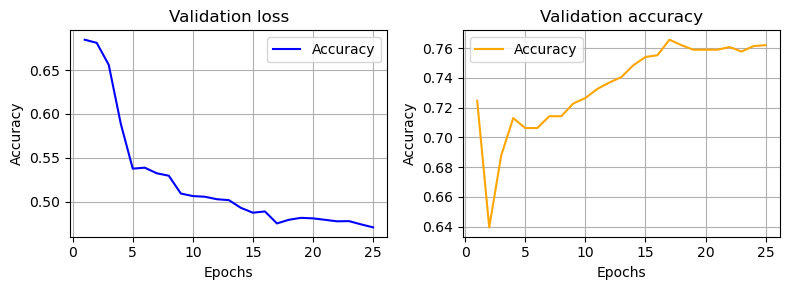

In [8]:
# Function to plot loss and accuracy
def plot_loss_accuracy(loss_values, accuracy_values):
    epochs = range(1, len(loss_values) + 1)

    plt.figure(figsize=(8, 3))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_values, label='Loss', color='blue')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy_values, label='Accuracy', color='orange')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 3))
    # Plot val loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, val_losses, label='Accuracy', color='blue')
    plt.title('Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    # Plot val accu
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracy_values, label='Accuracy', color='orange')
    plt.title('Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function after training
plot_loss_accuracy(loss_values, accuracy_values)

Files saved to:
/home/HardDisk/yared/training_plot.pdf
/home/HardDisk/yared/training_plot.png


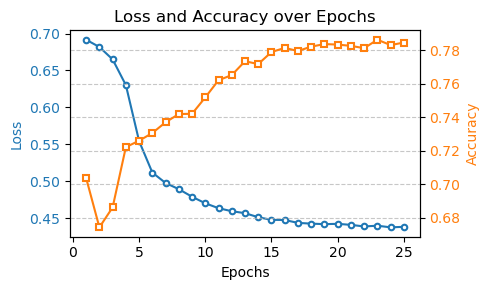

In [9]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

def plot_loss_accuracy(loss_values, accuracy_values):
    # Get current directory and create paths
    current_dir = os.getcwd()
    pdf_path = os.path.join(current_dir, 'training_plot.pdf')
    png_path = os.path.join(current_dir, 'training_plot.png')
    
    # Set up the plot with your original dimensions
    plt.figure(figsize=(5, 3))
    
    # Plot Loss (left y-axis) with enhanced styling
    plt.plot(range(1, len(loss_values) + 1), 
            loss_values, 
            label='Loss', 
            color='#1f77b4',
            marker='o',
            markerfacecolor='white',
            markeredgecolor='#1f77b4',
            markeredgewidth=1.5,
            markersize=4)
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss', color='#1f77b4')
    plt.tick_params(axis='y', labelcolor='#1f77b4')
    
    # Plot Accuracy (right y-axis) with enhanced styling
    ax2 = plt.gca().twinx()
    ax2.plot(range(1, len(accuracy_values) + 1), 
            accuracy_values, 
            label='Accuracy', 
            color='#ff7f0e',
            marker='s',
            markerfacecolor='white',
            markeredgecolor='#ff7f0e',
            markeredgewidth=1.5,
            markersize=4)
    
    ax2.set_ylabel('Accuracy', color='#ff7f0e')
    ax2.tick_params(axis='y', labelcolor='#ff7f0e')
    
    # Add titles and legends as in your original
    plt.title('Loss and Accuracy over Epochs')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Save high quality versions
    plt.savefig(pdf_path, format='pdf', dpi=300, bbox_inches='tight')
    plt.savefig(png_path, format='png', dpi=600, bbox_inches='tight')
    print(f"Files saved to:\n{pdf_path}\n{png_path}")
    
    plt.show()

# Your original function call remains the same
plot_loss_accuracy(loss_values, accuracy_values)

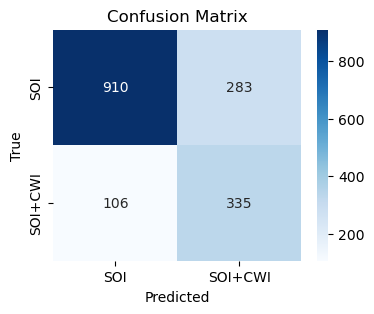


Classification Report:
              precision    recall  f1-score   support

         SOI       0.90      0.76      0.82      1193
     SOI+CWI       0.54      0.76      0.63       441

    accuracy                           0.76      1634
   macro avg       0.72      0.76      0.73      1634
weighted avg       0.80      0.76      0.77      1634



In [10]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['SOI', 'SOI+CWI'], yticklabels=['SOI', 'SOI+CWI'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['SOI', 'SOI+CWI']))

In [11]:
from sklearn.model_selection import train_test_split

# Assuming X and y are your features and labels for training data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)  # 20% for validation

# Prepare data loaders for training and validation
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train))
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val))
validation_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")


Precision: 0.5421, Recall: 0.7596, F1 Score: 0.6327, ROC-AUC: 0.7612
